Epoch 1, Train Loss: 0.6308, Val Loss: 0.3578, Train Acc: 0.8060, Val Acc: 0.8920
Epoch 2, Train Loss: 0.5284, Val Loss: 0.3496, Train Acc: 0.8389, Val Acc: 0.9046
Epoch 3, Train Loss: 0.5391, Val Loss: 0.3671, Train Acc: 0.8347, Val Acc: 0.8984
Epoch 4, Train Loss: 0.8803, Val Loss: 0.6990, Train Acc: 0.7171, Val Acc: 0.7859
Epoch 5, Train Loss: 1.4307, Val Loss: 2.3033, Train Acc: 0.4762, Val Acc: 0.1117
Early stopping at epoch 5


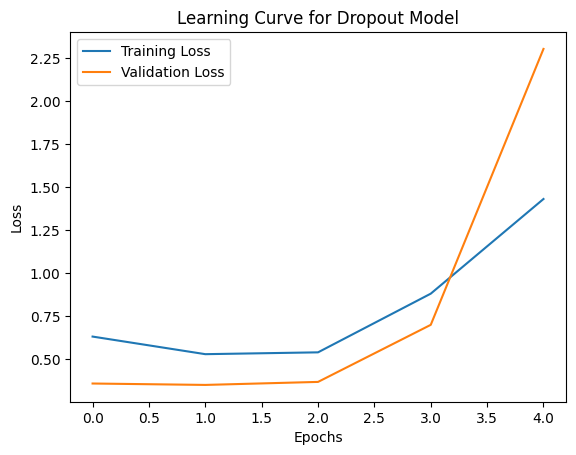

Test Loss: 2.3028, Test Accuracy: 0.1135


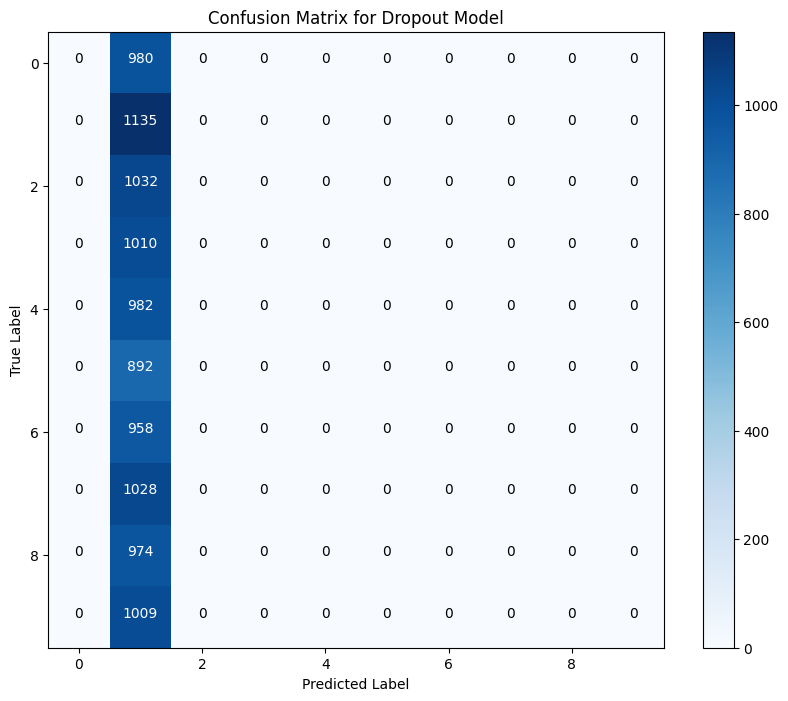

In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into train and validation sets
train_data, val_data = random_split(train_data, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=50, shuffle=False)
test_loader = DataLoader(test_data, batch_size=50, shuffle=False)

# Define the CNN model with Dropout
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(3 * 28 * 28, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)  # Apply dropout after the first convolutional layer
        x = F.relu(self.conv2(x))
        x = self.dropout(x)  # Apply dropout after the second convolutional layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x  # Return logits directly, CrossEntropyLoss will handle softmax

# Initialize model, optimizer, and loss function
model = CNNWithDropout(dropout_rate=0.5)  # Set dropout rate to 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for batch, labels in loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.size(0)
        correct += (output.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch, labels in loader:
            output = model(batch)
            loss = criterion(output, labels)
            total_loss += loss.item() * batch.size(0)
            correct += (output.argmax(1) == labels).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Optional early stopping
patience = 3  # Number of epochs to wait for improvement before stopping
trigger_times = 0
best_val_loss = float('inf')

# Train the model
epochs = 20
train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plot learning curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve for Dropout Model')
plt.show()

# Evaluate on test set and display confusion matrix
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Confusion matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for batch, labels in test_loader:
        output = model(batch)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confusion Matrix for Dropout Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", 
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

"""
Summary of Model Performance:
In the dropout model, we observe that the learning curve initially shows a decrease in training and validation loss,
indicating that the model is learning at the beginning. However, after a few epochs, both the training and validation 
loss increase sharply, suggesting that the model struggles to generalize. This is likely due to a high dropout rate 
(0.5), which causes the model to lose too much information during training, leading to underfitting. The test accuracy 
is very low (11.35%), close to random guessing, and the confusion matrix shows that the model mostly predicts the digit 
"0" for all test samples. This indicates that the high dropout rate prevents the model from learning useful features 
and patterns. To improve, we could reduce the dropout rate, allowing the model to retain more information during training 
and better distinguish between different digits.
"""
